# Модуль 2

## 2.1 Загрузка и разбитие данных на обучающий и тестовые наборы

In [2]:
# загрузка предобработанных данных

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


data_all = pd.read_csv('data_all.csv')
data_all.drop(columns=['Unnamed: 0'], inplace=True)
data_all.head(4)

,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,...,life_expectancy,human_development_index,tests_units_people tested,tests_units_samples tested,tests_units_tests performed,tests_units_units unclear,new_cases_4d,new_cases_prev_4d,Rt,target
0,5.0,5.0,0.0,0.0,0.0,0.0,0.126,0.126,0.0,0.0,...,64.83,0.511,False,False,True,False,0.0,0.0,0.0,2
1,5.0,0.0,0.0,0.0,0.0,0.0,0.126,0.000,0.0,0.0,...,64.83,0.511,False,False,True,False,0.0,0.0,0.0,2
2,5.0,0.0,0.0,0.0,0.0,0.0,0.126,0.000,0.0,0.0,...,64.83,0.511,False,False,True,False,0.0,0.0,0.0,2
3,5.0,0.0,0.0,0.0,0.0,0.0,0.126,0.000,0.0,0.0,...,64.83,0.511,False,False,True,False,5.0,0.0,0.0,2


In [13]:
!pip install seaborn

In [4]:
import seaborn as sns

In [5]:
X = data_all.drop(columns=['target'])
y = data_all['target']

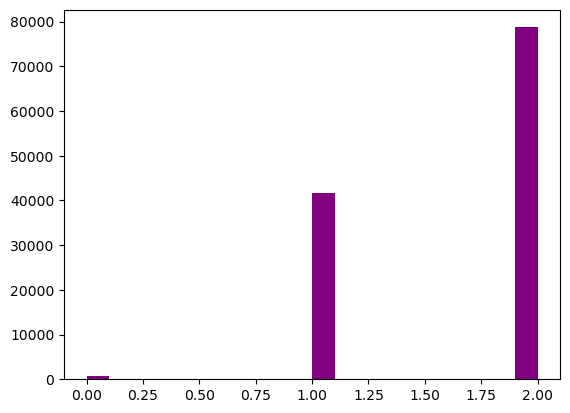

In [6]:
# посмотрим на распределенние значений челевого атрибута
y.hist(bins=20, color='purple')
plt.grid(False);

Есть дисбаланс, необходимо разбить данные с сохранением пропорциональности

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.3, random_state=2023, stratify=y)

In [8]:
y_train.value_counts(normalize=True)

target
2    0.650390
1    0.344428
0    0.005182
Name: proportion, dtype: float64

In [9]:
y_test.value_counts(normalize=True)

target
2    0.650409
1    0.344414
0    0.005177
Name: proportion, dtype: float64

## 2.2 Визуализация зависимостей данных

Посмотрим на корреляцию атрибутов и удалим сильно корелирующие значения

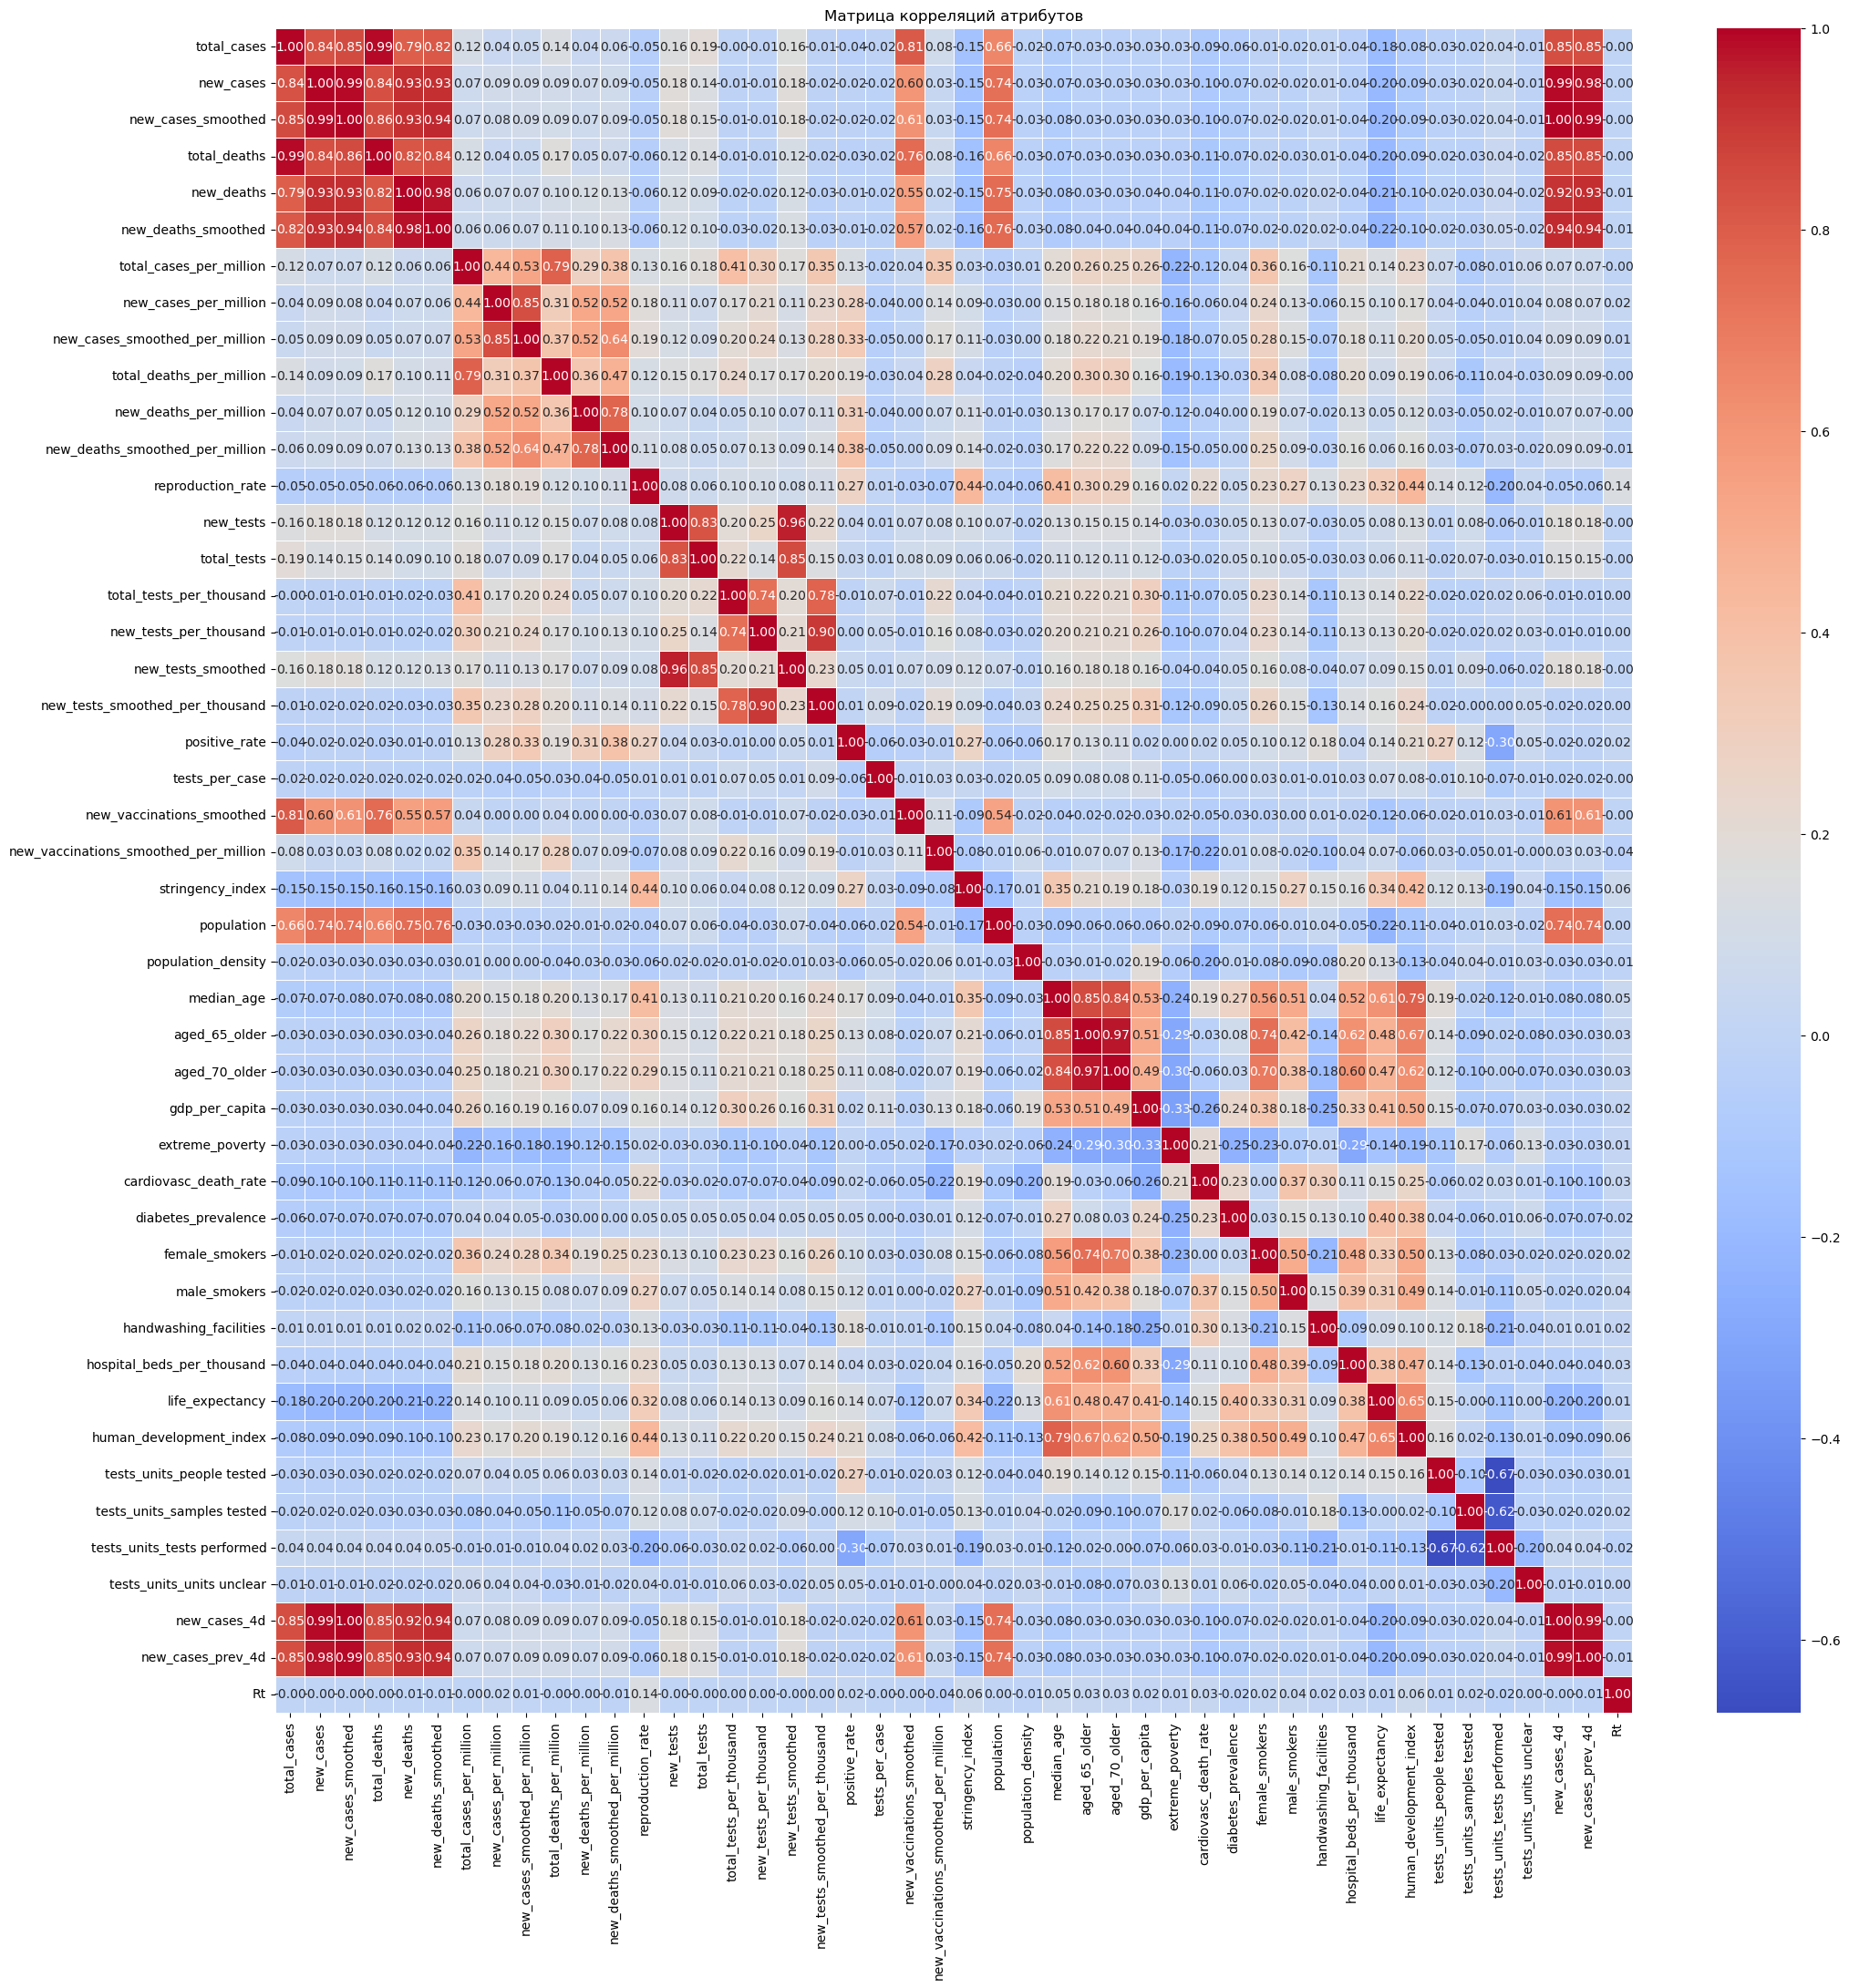

In [30]:
# Визуализация матрицы корреляций
correlation_matrix = X.corr()
plt.figure(figsize=(24, 24))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Матрица корреляций атрибутов')
plt.show()


Уадлим сильно корелирующие признаки

In [10]:
X.drop(columns=['new_cases_4d', 'new_cases_prev_4d', 'aged_65_older', 'new_tests_smoothed', 'new_deaths_smoothed', 'new_cases_smoothed'], inplace=True)

## 2.3 и 2.4 Классификация исходных компетенций и обучение

Для нашего набора данных подойдёт многоклассовая классификация. Для классификации будем использовать деревья принятия решений.

Как оценку точности будем использовать precision так как присудствует дисбаланс классов. Так же будем использовать полноту и f-меру.

In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

# соберём все метрики в одну функцию
def quality_report(prediction, actual):
    print("Precision: {:.3f}\nRecall: {:.3f}\nf1_score: {:.3f}".format(
        precision_score(prediction, actual, average='weighted'),
        recall_score(prediction, actual, average='weighted', zero_division=1),
        f1_score(prediction, actual, average='weighted')
    ))
    
    cnf_matrix = confusion_matrix(actual, prediction)
    plt.figure(figsize=(12, 10))
    
    # обычная матрица неточностей
    plt.subplot(2, 2, 1, 
                title='Матрица неточностей',
                ylabel='Истинные метки',
                xlabel='Прогнозы')
    sns.heatmap(cnf_matrix, annot=True)
    
    # нормализованная матрица неточностей
    cnf_matrix = cnf_matrix / cnf_matrix.sum(axis=1, keepdims=True)
    plt.subplot(2, 2, 2, 
                title='Матрица неточностей нормализованная',
                ylabel='Истинные метки',
                xlabel='Прогнозы')
    sns.heatmap(cnf_matrix, fmt='.1g', cmap=plt.cm.gray)

    plt.show();

Для начала попробуем DecisionTreeClassifier

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# попробуем сразу подобрать оптимальные параметры, чтобы избежать переобучения
tree_params = {
    'max_depth': list(range(20, 45)),
    'min_samples_leaf': [51, 55, 61, 65, 71, 75, 81]
}

locally_best_tree = GridSearchCV(DecisionTreeClassifier(random_state=2023, class_weight='balanced'), 
                                 tree_params, verbose=True, n_jobs=-1, cv=3, scoring='precision_weighted')
locally_best_tree.fit(X_train, y_train)
locally_best_tree.best_params_, round(locally_best_tree.best_score_, 3)

Fitting 3 folds for each of 175 candidates, totalling 525 fits


({'max_depth': 20, 'min_samples_leaf': 51}, 0.98)

На трейне
Precision: 0.985
Recall: 0.985
f1_score: 0.985


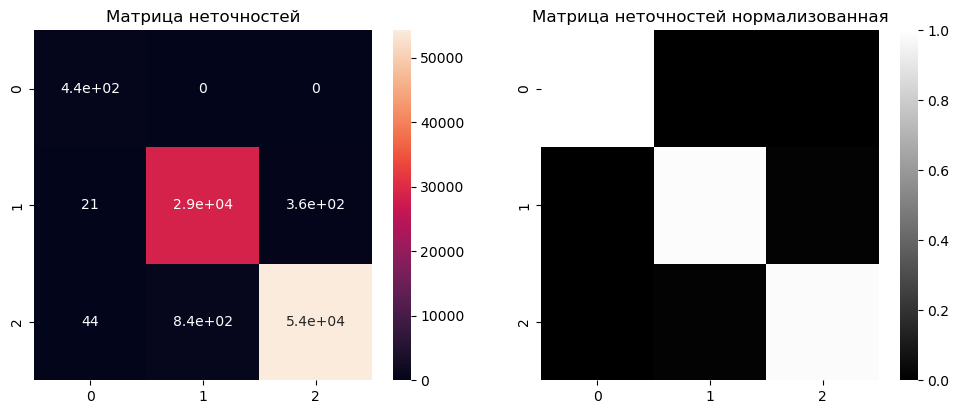

На тесте
Precision: 0.983
Recall: 0.983
f1_score: 0.983


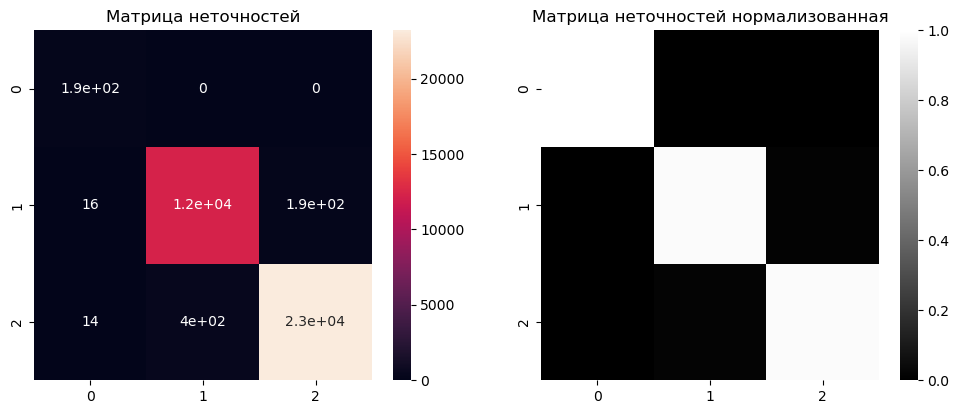

In [15]:
print('На трейне')
quality_report(locally_best_tree.best_estimator_.predict(X_train), y_train)
print('На тесте')
quality_report(locally_best_tree.predict(X_test), y_test)

Данная модель показала хороший результат и не показывает ни переобученности, ни недообученности.

Попробуем расмотреть другую модель и проверить качество обучение на другой моделе

In [16]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=300, max_depth=13, 
                                class_weight='balanced', n_jobs=-1)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=13, n_estimators=300,
                       n_jobs=-1)

На трейне
Precision: 0.999
Recall: 0.999
f1_score: 0.999


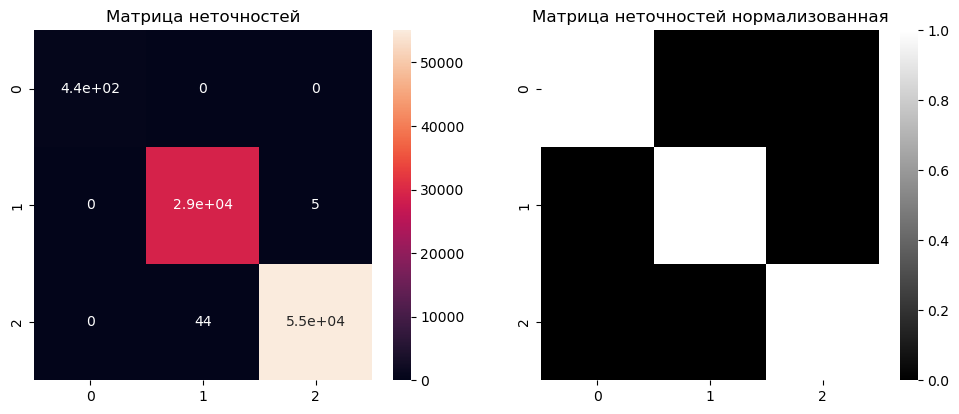

На тесте
Precision: 0.995
Recall: 0.995
f1_score: 0.995


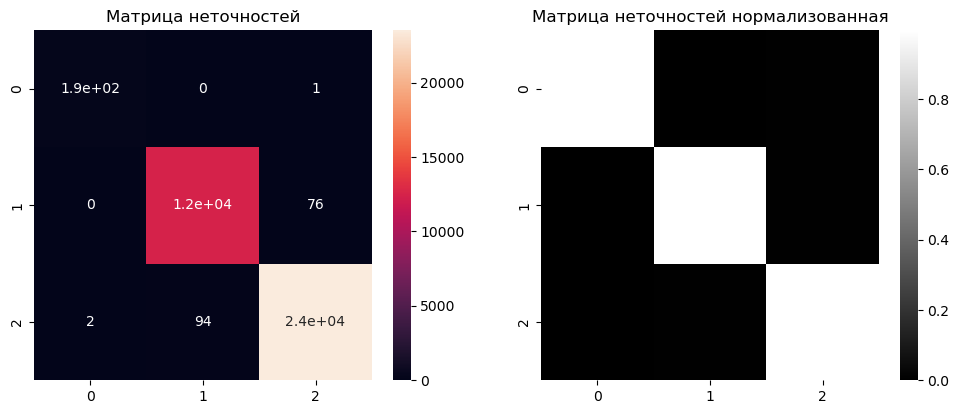

In [17]:
print('На трейне')
quality_report(rf_clf.predict(X_train), y_train)
print('На тесте')
quality_report(rf_clf.predict(X_test), y_test)

Модель показала результаты выше преыдушей, а также немного путает одни кассы с другими. Но результаты слишком велеки и если дополнять набор новыми признаками или оптимизировать его то возможно переобучение.

## 2.5 Feature Engineering

Попробуем преобразовать наши данные и посмотреть возникнит ли переобучение для второй модели

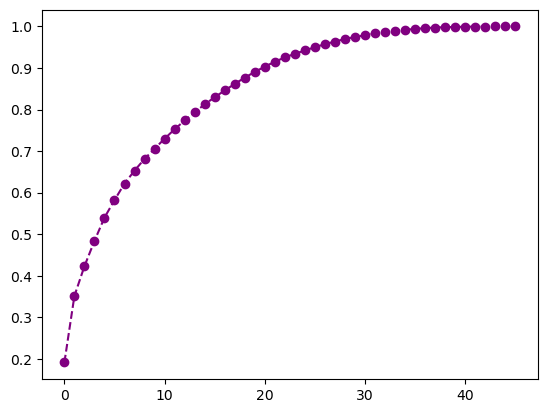

In [18]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_train_scaled = StandardScaler().fit_transform(X_train)
X_test_scaled = StandardScaler().fit_transform(X_test)

pca = PCA()
pca.fit(X_train_scaled) # передаются стандартизированные данные

# построим график, на котором отражено нарастание доли объяснённой дисперсии
# в зависимости от увеличения выбора количества компонент
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'o--', color='purple');

На графике видно что 35 признаков объясняет 98% дисперсии поэтому попробуем взять только 35 признаков и обучить оба набора и посмотреть как себя поведут модели

In [20]:
X_train_new = PCA(n_components=35).fit_transform(X_train_scaled)
X_test_new = PCA(n_components=35).fit_transform(X_test_scaled)

На трейне
Precision: 0.982
Recall: 0.664
f1_score: 0.783


D:\anaconda\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


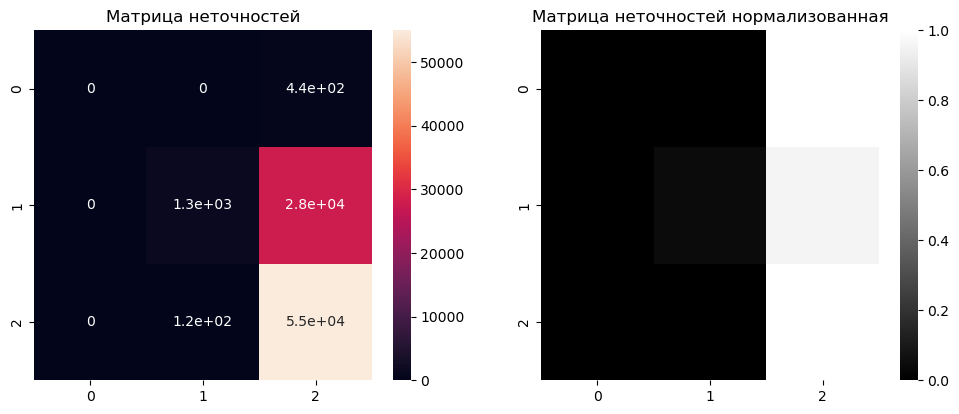

На тесте
Precision: 0.983
Recall: 0.664
f1_score: 0.783


D:\anaconda\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


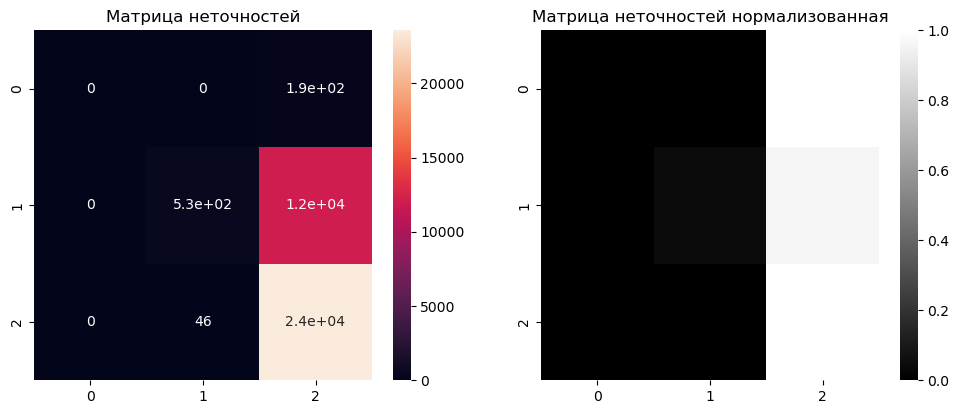

In [22]:
# DecisionTreeClassifier
print('На трейне')
quality_report(locally_best_tree.best_estimator_.predict(X_train_scaled), y_train)
print('На тесте')
quality_report(locally_best_tree.predict(X_test_scaled), y_test)

На трейне


D:\anaconda\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Precision: 1.000
Recall: 0.650
f1_score: 0.788


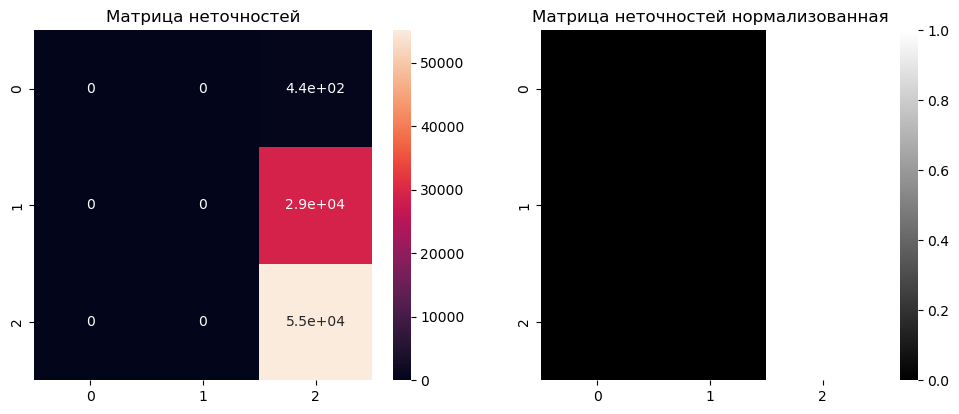

На тесте
Precision: 1.000
Recall: 0.650
f1_score: 0.788


D:\anaconda\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


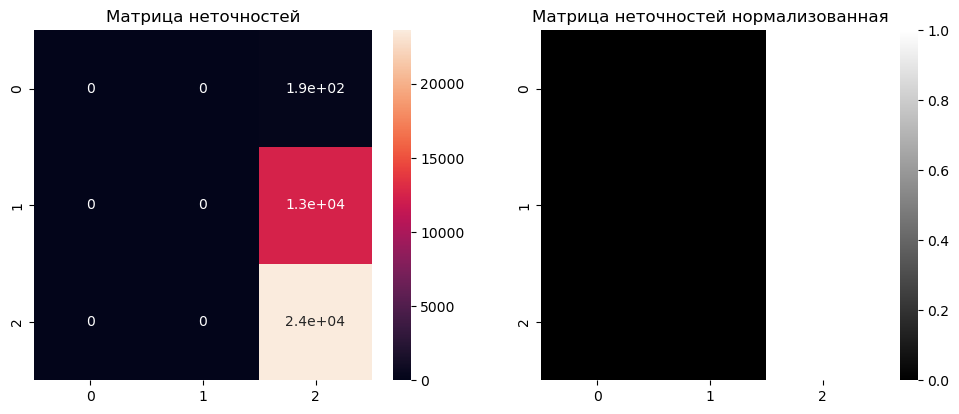

In [23]:
#  RandomForestClassifier
print('На трейне')
quality_report(rf_clf.predict(X_train_scaled), y_train)
print('На тесте')
quality_report(rf_clf.predict(X_test_scaled), y_test)

Первая модель понизила свои показатели а у второй модели возникло переобучение. Это значит что преобразование данных не помогло нашим моделем